# Debugging in JAX: a Variational autoencoder (VAE) model

In [Getting started with JAX](https://jax-ai-stack.readthedocs.io/en/latest/getting_started_with_jax_for_AI.html) we built a simple neural network for classification of handwritten digits, and covered some of the key features of JAX, including its NumPy-style interface in the `jax.numpy`, as well as its transformations for JIT compilation with `jax.jit`, automatic vectorization with `jax.vmap`, and automatic differentiation with `jax.grad`.

This tutorial will explore a slightly more involved model: a simplified version of a [Variational Autoencoder (VAE)](https://en.wikipedia.org/wiki/Variational_autoencoder) trained on the same simple digits data. Along the way, we'll learn a bit more about how JAX's JIT compilation actually works, and what this means for debugging JAX programs.

## Loading the digits

As before, we'll use the small, self-contained [scikit-learn digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) for ease of experimentation:

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import jax.numpy as jnp

digits = load_digits()

splits = train_test_split(digits.images, random_state=0)

images_train, images_test = map(jnp.asarray, splits)

print(f"{images_train.shape=}")
print(f"{images_test.shape=}")

images_train.shape=(1347, 8, 8)
images_test.shape=(450, 8, 8)


The dataset comprises 1800 images, each represented by an 8x8 pixel grid.
To see a visualization of this data, refer to [loading the data](https://jax-ai-stack.readthedocs.io/en/latest/getting_started_with_jax_for_AI.html#loading-the-data) in the previous tutorial.

## Defining the Variational Autoencoder

Previously we defined a simple feedforward network trained for classification with an architecture that looked roughly like this:

In [2]:
import jax
import jax.numpy as jnp
from flax import nnx

class SimpleNN(nnx.Module):

  def __init__(self, n_features=64, n_hidden=100, n_targets=10, *, rngs: nnx.Rngs):
    self.layer1 = nnx.Linear(n_features, n_hidden, rngs=rngs)
    self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
    self.layer3 = nnx.Linear(n_hidden, n_targets, rngs=rngs)

  def __call__(self, x: jax.Array) -> jax.Array:
    x = nnx.selu(self.layer1(x))
    x = nnx.selu(self.layer2(x))
    return self.layer3(x)

In this network we had one output per class, and the loss function was designed such that once trained, the output corresponding to the correct class would return the strongest signal, thus predicting the correct label in upwards of 95% of cases.

In this VAE example we use similar building blocks to instead output a small probabilisitic model representing the data. While classic `VAE` is generally based on convolutional layers, we use linear layers for simplicity. The sub-network that produces this probabilistic encoding is our `Encoder`:

In [3]:
class Encoder(nnx.Module):
  def __init__(self, input_size: int, intermediate_size: int, output_size: int,
               *, rngs: nnx.Rngs):
    self.rngs = rngs
    self.linear = nnx.Linear(input_size, intermediate_size, rngs=rngs)
    self.linear_mean = nnx.Linear(intermediate_size, output_size, rngs=rngs)
    self.linear_std = nnx.Linear(intermediate_size, output_size, rngs=rngs)

  def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    x = self.linear(x)
    x = jax.nn.relu(x)

    mean = self.linear_mean(x)
    std = jnp.exp(self.linear_std(x))

    key = self.rngs.noise()
    z = mean + std * jax.random.normal(key, mean.shape)
    return z, mean, std

The idea here is that `mean` and `std` define a low-dimensional probability distribution over a latent space, and that `z` is a draw from this latent space that represents the training data.

In order to ensure that this latent distribution faithfully represents the actual data, we define a `Decoder` that maps back to the input space:

In [4]:
class Decoder(nnx.Module):
  def __init__(self, input_size: int, intermediate_size: int, output_size: int,
               *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(input_size, intermediate_size, rngs=rngs)
    self.linear2 = nnx.Linear(intermediate_size, output_size, rngs=rngs)

  def __call__(self, z: jax.Array) -> jax.Array:
    z = self.linear1(z)
    z = jax.nn.relu(z)
    logits = self.linear2(z)
    return logits

Now the full VAE model is a single network built from the encoder and decoder.
It returns both the reconstructed image and then internal latent space model:

In [5]:
class VAE(nnx.Module):
  def __init__(
    self,
    image_shape: tuple[int, int],
    hidden_size: int,
    latent_size: int,
    *,
    rngs: nnx.Rngs
  ):
    self.image_shape = image_shape
    self.latent_size = latent_size
    input_size = image_shape[0] * image_shape[1]
    self.encoder = Encoder(input_size, hidden_size, latent_size, rngs=rngs)
    self.decoder = Decoder(latent_size, hidden_size, input_size, rngs=rngs)

  def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    x = jax.vmap(jax.numpy.ravel)(x)  # flatten
    z, mean, std = self.encoder(x)
    logits = self.decoder(z)
    logits = jnp.reshape(logits, (-1, *self.image_shape))
    return logits, mean, std

Next is the loss function – there are two components to the model that we want to ensure:

1. the `logits` output faithfully reconstruct the input image.
2. the model represented by `mean` and `std` faithfully represents the "true" latent distribution.

VAE uses a loss function based on the [Evidence lower bound](https://en.wikipedia.org/wiki/Evidence_lower_bound) to quantify theset two goals in a single loss value:

In [6]:
def vae_loss(model: VAE, x: jax.Array):
  logits, mean, std = model(x)
  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  reconstruction_loss = jnp.mean(
    optax.sigmoid_binary_cross_entropy(logits, x)
  )
  return reconstruction_loss + 0.1 * kl_loss

Now all that's left is to define the model and optimizer, and run the training loop:

In [7]:
import optax

model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

@nnx.jit
def train_step(model: VAE, optimizer: nnx.Optimizer, x: jax.Array):
  loss, grads = nnx.value_and_grad(vae_loss)(model, x)
  optimizer.update(grads)
  return loss

for epoch in range(2001):
  loss = train_step(model, optimizer, images_train)
  if epoch % 500 == 0:
    print(f'Epoch {epoch} loss: {loss}')

Epoch 0 loss: 16745235.0
Epoch 500 loss: nan
Epoch 1000 loss: nan
Epoch 1500 loss: nan
Epoch 2000 loss: nan


And here we see that something has gone wrong: our loss value has become NaN after some number of iterations.

## Debugging NaNs in JAX
Despite our best efforts, our model is producing NaNs. What can we do?

JAX offers a number of debugging approaches for situations like this, outlined in the JAX docs at [Debugging runtime values](https://jax.readthedocs.io/en/latest/debugging/index.html). In this case we can use the [`debug_nans`](https://jax.readthedocs.io/en/latest/debugging/flags.html#jax-debug-nans-configuration-option-and-context-manager) configuration to see where the NaN value is arising:

In [8]:
model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

with jax.debug_nans(True):
  for epoch in range(2001):
    train_step(model, optimizer, images_train)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(dot_general). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

The output here is complicated, because the function we're evaluating is complicated, but the key to deciphering this traceback is to look for the places where the traceback touches your implementation. In particular here, it indicates that NaN values arise during the gradient update:
```
<ipython-input-9-b5b28eeeadf6> in train_step()
     14   loss, grads = nnx.value_and_grad(vae_loss)(model, x)
---> 15   optimizer.update(grads)
     16   return loss
```
and further down from this, the details of the gradient update step where the NaN is arising:
```
/usr/local/lib/python3.10/dist-packages/optax/tree_utils/_tree_math.py in <lambda>()
    280       lambda g, t: (
--> 281           (1 - decay) * (g**order) + decay * t if g is not None else None
    282       ),
```
This tells us that the gradient is returning values that lead to `NaN` during the model update: typically this would come about when the gradient itself is for some reason diverging.

A diverging gradient means that something with our loss function may be amiss. We previously saw `loss=NaN` at iteration 500; let's print the progress up to this point:

In [9]:
model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

for epoch in range(301):
  loss = train_step(model, optimizer, images_train)
  if epoch % 50 == 0:
    print(f'Epoch {epoch} loss: {loss}')

Epoch 0 loss: 16745235.0
Epoch 50 loss: 19.595727920532227
Epoch 100 loss: -13.440512657165527
Epoch 150 loss: -145.24871826171875
Epoch 200 loss: -683.0828247070312
Epoch 250 loss: -2291.444091796875
Epoch 300 loss: -6880.775390625


It looks like our loss value is decreasing toward negative infinity until the point where the values are no longer well-represented by floating point math.

At this point, we may wish to expect the values within the loss function itself to see where the diverging loss might be coming from.
In typical Python programs you can do this by inserting either a `print` statement or a `breakpoint` in the loss function; it might look something like this:

In [10]:
def vae_loss(model: VAE, x: jax.Array):
  logits, mean, std = model(x)
  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  reconstruction_loss = jnp.mean(
    optax.sigmoid_binary_cross_entropy(logits, x)
  )
  print("kl loss", kl_loss)
  print("reconstruction loss", reconstruction_loss)
  return reconstruction_loss + 0.1 * kl_loss

model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))
train_step(model, optimizer, images_train)

kl loss Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7b9be70b1b20>, in_tracers=(Traced<ShapedArray(float32[1347]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7b9be6aecb30; to 'JaxprTracer' at 0x7b9be6aecae0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1347]. let
    b:f32[] = reduce_sum[axes=(0,)] a
    c:f32[] = div b 1347.0
  in (c,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None,), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False,), 'name': '_mean', 'keep_unused': False, 'inline': True}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x7b9be6ae38b0>, ctx=JaxprEqnContex

Array(16745235., dtype=float32)

But here rather than printing the value, we're getting some kind of `Traced` object. You'll encounter this frequently when inspecting the progress of JAX programs: tracers are the mechanism that JAX uses to implement transformations like `jit` and `grad`, and you can read more about them in [JAX Key Concepts: Tracing](https://jax.readthedocs.io/en/latest/key-concepts.html#tracing).

For our purposes, the workaround is to use another tool from the [Debugging runtime values](https://jax.readthedocs.io/en/latest/debugging/index.html#interactive-inspection-with-jax-debug) link above: namely `jax.debug.print`, which lets us print runtime values even when they're traced:

In [11]:
def vae_loss(model: VAE, x: jax.Array):
  logits, mean, std = model(x)

  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  reconstruction_loss = jnp.mean(
    optax.sigmoid_binary_cross_entropy(logits, x)
  )
  jax.debug.print("kl_loss: {}", kl_loss)
  jax.debug.print("reconstruction_loss: {}", reconstruction_loss)
  return reconstruction_loss + 0.1 * kl_loss

model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

for i in range(5):
  train_step(model, optimizer, images_train)

kl_loss: 167451888.0
reconstruction_loss: 44.51668167114258
kl_loss: 21651530.0
reconstruction_loss: 6.270397186279297
kl_loss: 4448844.5
reconstruction_loss: -14.727174758911133
kl_loss: 1285240.625


Let's iterate a few hundred more times (we'll use the IPython `%%capture` magic to avoid printing all the output on the first several hundred iterations) and then do one more run to print these intermediate values:

In [12]:
%%capture
for i in range(300):
  train_step(model, optimizer, images_train)

In [13]:
loss = train_step(model, optimizer, images_train)

kl_loss: 2462.782470703125
reconstruction_loss: -8067.7255859375


We see that the large negative value is coming from the `reconstruction_loss` term. Let's return to this and look at what it's actually doing:
```python
reconstruction_loss = jnp.mean(
  optax.sigmoid_binary_cross_entropy(logits, x)
)
```
This is a binary cross entropy described at [`optax.sigmoid_binary_cross_entropy`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.losses.sigmoid_binary_cross_entropy). From the documentation, the first input should be a logit, and the second input is assumed to be a binary label (i.e. a ``0`` or ``1``) – but in our case `x` is associated with `images_train`, which is not a binary label!

In [14]:
print(images_train[0])

[[ 0.  3. 13. 16.  9.  0.  0.  0.]
 [ 0. 10. 15. 13. 15.  2.  0.  0.]
 [ 0. 15.  4.  4. 16.  1.  0.  0.]
 [ 0.  0.  0.  5. 16.  2.  0.  0.]
 [ 0.  0.  1. 14. 13.  0.  0.  0.]
 [ 0.  0. 10. 16.  5.  0.  0.  0.]
 [ 0.  4. 16. 13.  8. 10.  9.  1.]
 [ 0.  2. 16. 16. 14. 12.  9.  1.]]


This is likely the source of our issue: we forgot to normalize the input images to the range ``(0, 1)``!

Let's fix this by binarizing our inputs, and then run the training loop again (redefining our loss function to remove the debug statements):

In [15]:
images_normed = (digits.images / 16) > 0.5
splits = train_test_split(images_normed, random_state=0)
images_train, images_test = map(jnp.asarray, splits)

def vae_loss(model: VAE, x: jax.Array):
  logits, mean, std = model(x)

  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  reconstruction_loss = jnp.mean(
    optax.sigmoid_binary_cross_entropy(logits, x)
  )
  return reconstruction_loss + 0.1 * kl_loss

model = VAE(
  image_shape=(8, 8),
  hidden_size=32,
  latent_size=8,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

for epoch in range(2001):
  loss = train_step(model, optimizer, images_train)
  if epoch % 500 == 0:
    print(f'Epoch {epoch} loss: {loss}')

Epoch 0 loss: 0.7710005640983582
Epoch 500 loss: 0.3110124468803406
Epoch 1000 loss: 0.2782602906227112
Epoch 1500 loss: 0.26861754059791565
Epoch 2000 loss: 0.26275068521499634


The loss values are now behaving, and it looks like we've successfully debugged the initial NaN problem, which was not in our model but rather in our input data.

## Exploring the VAE model results

Now that we have a trained model, let's explore what it can be used for.
First, let's pass our test data through the model to output the result of the associated latent space representation for each input. We pass the `logits` through a `sigmoid` function to recover predicted images in the input space:

In [16]:
logits, mean, std = model(images_test)
images_pred = jax.nn.sigmoid(logits)

Let's visualize several of these inputs and outputs:

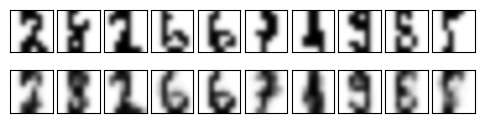

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 10, figsize=(6, 1.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
  ax[0, i].imshow(images_test[i], cmap='binary', interpolation='gaussian')
  ax[1, i].imshow(images_pred[i], cmap='binary', interpolation='gaussian')

The top row here are the input images, and the bottom row are what the model "thinks" these images look like, given their latent space representation.
There's not perfect fidelity, but the essential features are recovered.

We can go a step further and generate a set of new images from scratch by sampling randomly from the latent space. Let's generate 36 new digits this way:

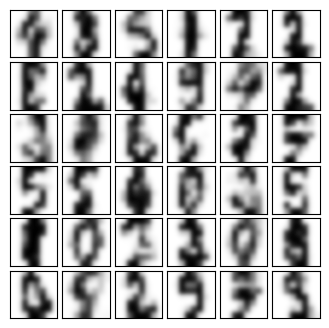

In [18]:
import numpy as np

# generate new images by sampling the latent space
z = np.random.normal(scale=1.5, size=(36, model.latent_size))
logits = model.decoder(z).reshape(-1, 8, 8)
images_gen = nnx.sigmoid(logits)

fig, ax = plt.subplots(6, 6, figsize=(4, 4),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(36):
  ax.flat[i].imshow(images_gen[i], cmap='binary', interpolation='gaussian')

Another possibility here is to use our latent model to interpolate between two entries in the training set through the latent model space.
Here's an interpolation between a digit 9 and a digit 3:

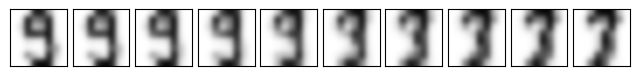

In [19]:
z, _, _ = model.encoder(images_train.reshape(-1, 64))
zrange = jnp.linspace(z[2], z[9], 10)

logits = model.decoder(zrange).reshape(-1, 8, 8)
images_gen = nnx.sigmoid(logits)

fig, ax = plt.subplots(1, 10, figsize=(8, 1),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
  ax.flat[i].imshow(images_gen[i], cmap='binary', interpolation='gaussian')

## Summary

This tutorial offered a first example defining and training a generative model, in this case a simplified Variational Autoencoder (VAE).
Along the way we explored some approaches to debugging JAX programs, in particular the `jax.debug_nans` setting and the `jax.debug.print` function. Both of these are explained further in JAX's [Debugging runtime values](https://jax.readthedocs.io/en/latest/debugging/index.html) doc.